In [48]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors

In [2]:
df_wine = pd.read_csv('/kaggle/input/datasets-rpaa-p7/wine.csv')
df_clusters = pd.read_csv('/kaggle/input/datasets-rpaa-p7/clusters.csv')
np.random.seed(42)

# Exploración de `df_wine`

In [3]:
df_wine.head()

alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proline  target  
0                          3.92   1065.0       0  
1                          3.40   1050.0       0  
2                          3.17   1185.0       0  
3                          3.45   1480.0       0  
4                          2.93    735.0       0

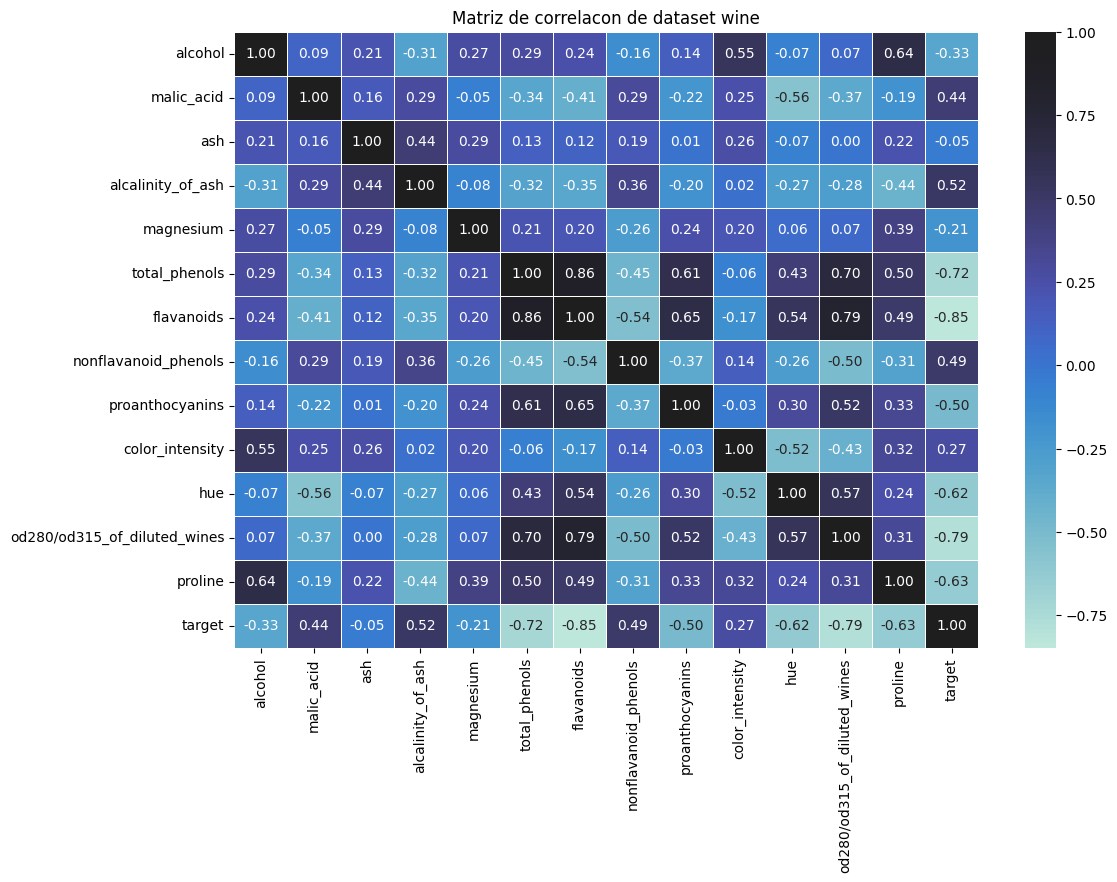

In [4]:
plt.figure(figsize=(12,8))
sns.heatmap(df_wine.corr(), annot=True, linewidths=0.5, fmt='.2f', center=1)
plt.title("Matriz de correlacon de dataset wine")
plt.show()

De la matriz de correlación anterior, notemos que la mayoría de características tienen una correlación baja, salvo algunas características de los datos.

Notemos que las primeras tres características tienen correlaciones relativamente altes y que el par `total_phenols` y `flavanoids` poseen correlación muy alta, por lo que también serán descartaremos la última. 
También se presenta una correlación considerable con `proanthocyanins`, `hue`, `od280/od315_of_diluted_wines`, `proline` y `target` así que también serán descartadas. Esto nos deja con las siguientes características para el algoritmo: `[alcalinity_of_ash, magnesium, total_phenols, proanthocyanins, nonflavanoid_phenols, color_intensity, hue]`. Observemos la matriz que tenemos con estos datos.

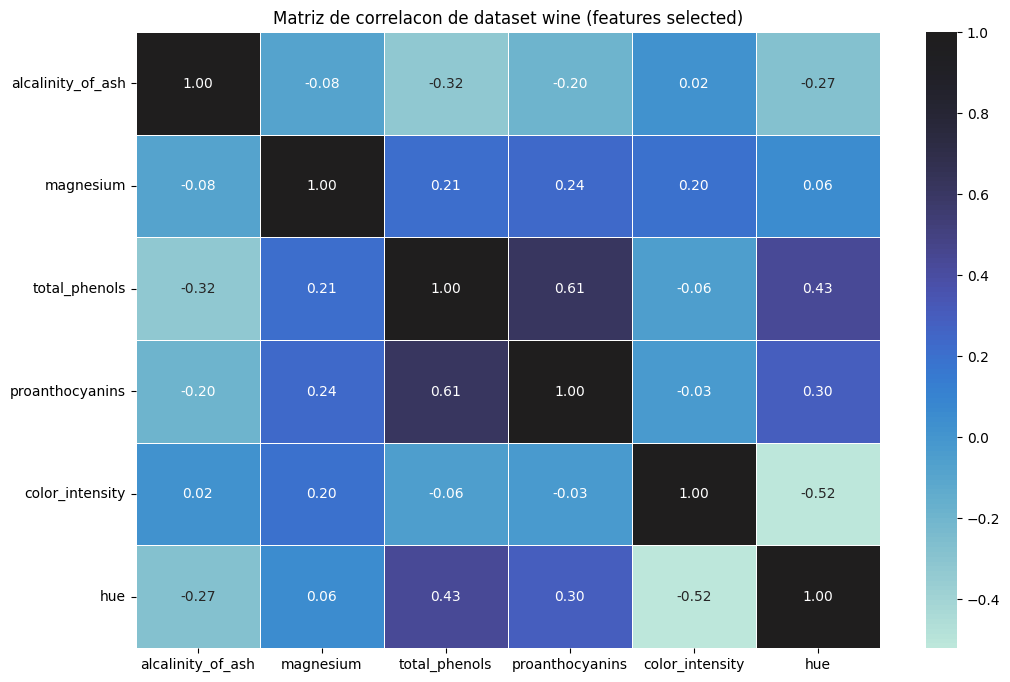

In [5]:
df_wine = df_wine[['alcalinity_of_ash', 'magnesium', 'total_phenols', 'proanthocyanins', 'color_intensity', 'hue']]
plt.figure(figsize=(12,8))
sns.heatmap(df_wine.corr(), annot=True, linewidths=0.5, fmt='.2f', center=1)
plt.title("Matriz de correlacon de dataset wine (features selected)")
plt.show()

Observamos que tenemos características con menos correlación, salvo el par `total_phenols` y `proanthocyanins`, que consideramos de relevancia. 

# I
--- 
Usando K-means y el archivo wine.csv realiza los siguientes ejercicios:
1. Para $k = 1, \dotsc, 10$. Calcula el WCSS para cada k y graficalos.
1. Justifica qué valor de $k$ sería el más óptimo
1. Obtén las diferentes clases de vinos.

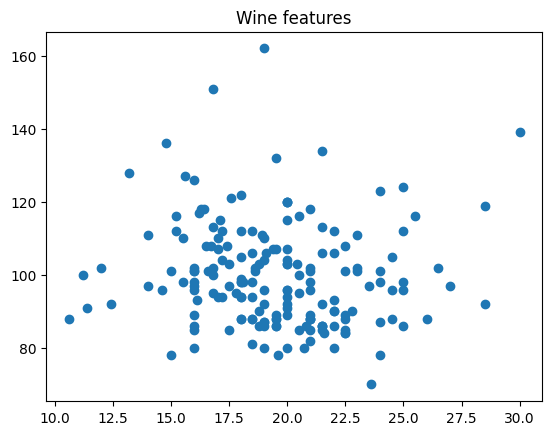

In [6]:
X_wine = df_wine.values
plt.scatter(X_wine[:, 0], X_wine[:, 1])
plt.title('Wine features')
plt.show()

In [27]:
def plot_metric(start, end, data, **kwargs):
    iterable = range(start, end + 1)
    title = kwargs.get('title', "Plot")
    x_label = kwargs.get('x_label', "$X$")
    y_label = kwargs.get('y_label', "$Y$")
    plt.plot(iterable, data)
    plt.scatter(iterable, data)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

In [7]:
K = 10
wcss = []
silhouette_scores = []
db_scores = []

for i in range(2, K + 1):
        kmeans = KMeans(n_clusters=i, init='k-means++', n_init='auto', random_state=42)
        kmeans.fit(X_wine)
        wcss.append(kmeans.inertia_)
        silhouette_avg = silhouette_score(X_wine, kmeans.labels_)
        db_score = davies_bouldin_score(X_wine, kmeans.labels_)
        silhouette_scores.append(silhouette_avg)
        db_scores.append(db_score)

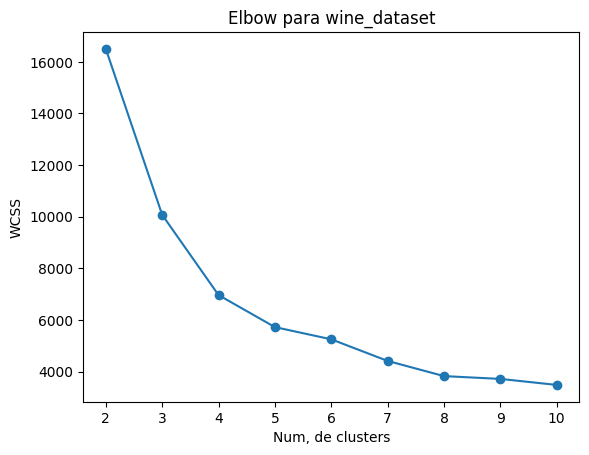

In [29]:
plot_metric(2, K, wcss, title='Elbow para wine_dataset', 
            x_label='Num, de clusters', y_label='WCSS')

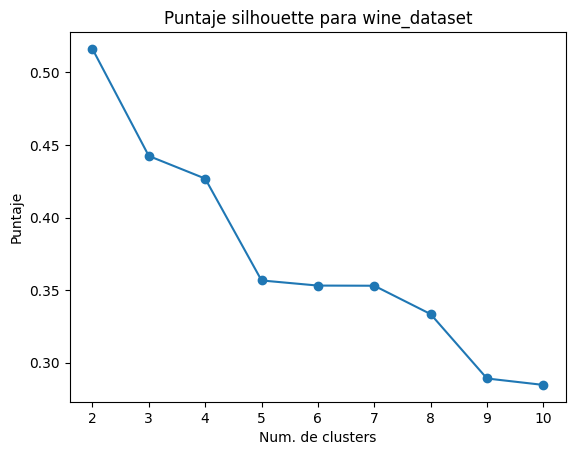

In [31]:
plot_metric(2, K, silhouette_scores, title='Puntaje silhouette para wine_dataset',
           x_label='Num. de clusters', y_label='Puntaje')

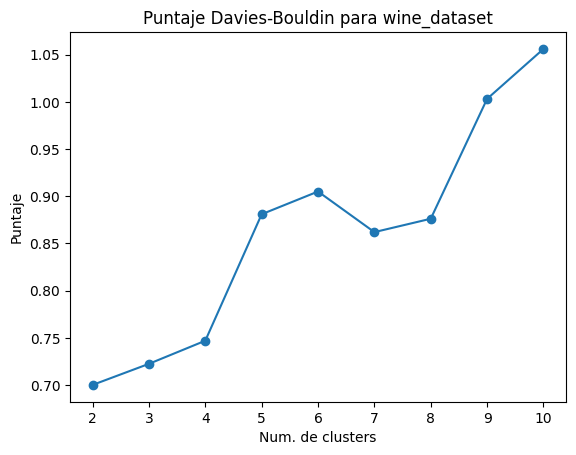

In [33]:
plot_metric(2, K, db_scores, title='Puntaje Davies-Bouldin para wine_dataset',
           x_label='Num. de clusters', y_label='Puntaje')

El valor más óptimo corresponde al número de clústers 4, dado que es el punto donde la gráfica de WCSS muestra un cambio 
significativo decreciente, silhouette también presenta uno de los puntos más altos en cuatro y aunque Davies-Bouldin da un puntaje menor para candidatos más pequeños, cuatro sigue siendo un número adecuado dado que se encuentra entre los tres con menor puntuación.

In [60]:
def plot_clusters(X, y=None, **kwargs):
    point_size = kwargs.get('s', 50)
    plotter = kwargs.get('ax', plt)
    plotter.scatter(X[:,0], X[:,1], c=y, s=point_size)
    centroids = kwargs.get('plot_centroids', True)
    
    if centroids:
        cent_coords = kwargs.get('centroids', None)
        if cent_coords is not None:
            plotter.scatter(cent_coords[:, 0], cent_coords[:, 1],
                        s=point_size*2, c='red', label='centroids')
    plt.tight_layout()
    if kwargs.get('legend', False): plt.legend()
    if kwargs.get('show', False): plt.show()

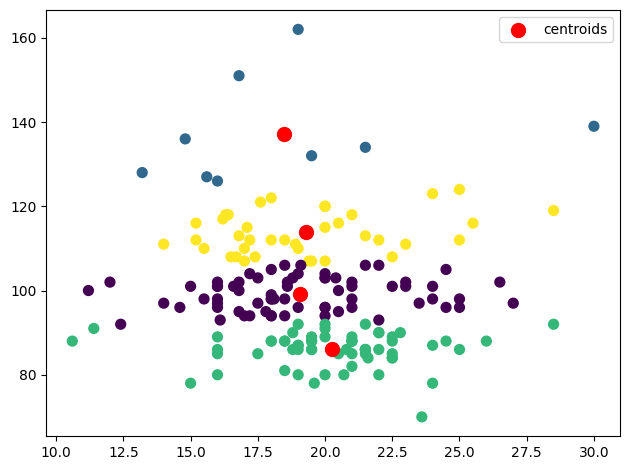

In [12]:
N_CLUSTERS = 4
kmeans_c = KMeans(n_clusters=N_CLUSTERS, init='k-means++', 
                  n_init='auto', random_state=42)
y_pred = kmeans_c.fit_predict(X_wine)
cmap = plt.get_cmap('plasma', N_CLUSTERS)

plot_clusters(X_wine, y_pred, plot_centroids=True, 
              centroids=kmeans_c.cluster_centers_,
              legend=True, show=True)

# II
Usando el archivo `clusters.csv` realiza lo siguiente:
1. Utiliza Hierarchical clustering, K-Means, DBSCAN y GaussianMixture para obtener los diferentes clusters.
1. Utiliza al menos tres formas de evaluar los resultados de los algoritmos utilizados.
1. Prueba diferentes hiperparámetros en cada uno de los modelos y reporta aquellos que produzcan los mejores resutados.
1. ¿Cuál es el número óptimo de clusters para este conjunto de datos? Justifica tu respuesta.
1. Compara los resultados entre los diferentes algoritmos. ¿Cuál es el mejor algoritmo para clasificar este conjunto de datos?

In [49]:
def cluster_strat(data, strat='kmeans', **kwargs):
    match strat:
        case 'hierarchy':
            n_clusters = kwargs.get('n_clusters', 5)
            linkage = kwargs.get('linkage', 'ward')
            algo = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', 
                                           linkage=linkage).fit(data)
            
        case 'dbscan':
            epsilon = kwargs.get('epsilon', 0.25)
            samples = kwargs.get('samples', 2)
            algo = DBSCAN(eps=epsilon, min_samples=samples ,n_jobs=-1).fit(data)
            
        case 'gmm':
            n_components = kwargs.get('n_components', 5)
            algo = GaussianMixture(n_components=n_components, n_init=7, 
                                   random_state=42).fit(data)
            
        case _:
            n_clusters = kwargs.get('n_clusters', 5)
            algo = KMeans(n_clusters=n_clusters, init='k-means++',
                          random_state=42, n_init='auto').fit(data)
            
    return algo

def iterate_strat(strat, data, init, 
                 end, n, m):
    N_ROWS = n
    N_COLS = m
    fig, axs = plt.subplots(N_ROWS, N_COLS, figsize=(25,10))

    wcss = []
    silhouette_scores = []
    db_scores = []
    bics = []
    aics = []
    for col_idx, i in enumerate(range(init, end + 1)):
        plot_row = 0 if i <= (N_COLS+1) else 1
        algo = cluster_strat(data, strat=strat, n_clusters=i)
        
        labls = algo.labels_ if strat not in ['gmm'] else algo.predict(data)
        if strat not in ['hierarchy', 'gmm', 'dbscan']:
            wcss.append(algo.inertia_)
        elif strat in ['gmm']:
            bics.append(algo.bic(data))
            aics.append(algo.aic(data))
        
        silhouette_avg = silhouette_score(data, algo.labels_)
        db_score = davies_bouldin_score(data, algo.labels_)
        silhouette_scores.append(silhouette_avg)
        db_scores.append(db_score)
        
        axs[plot_row, col_idx % N_COLS].set_title(f"{strat} using {i} clusters")
        plot_clusters(X_clusters, kmean.labels_, s=10, ax=axs[plot_row, col_idx % N_COLS])
        
    plt.show()
    if strat == 'kmeans':
        plot_metric(init, end, wcss, title='Elbow para wine_dataset', 
                x_label='Num, de clusters', y_label='WCSS')
        
    plot_metric(init, end, silhouette_scores, title='Puntaje silhouette para wine_dataset',
                x_label='Num. de clusters', y_label='Puntaje')
    
    plot_metric(init, end, db_scores, title='Puntaje Davies-Bouldin para wine_dataset',
           x_label='Num. de clusters', y_label='Puntaje')

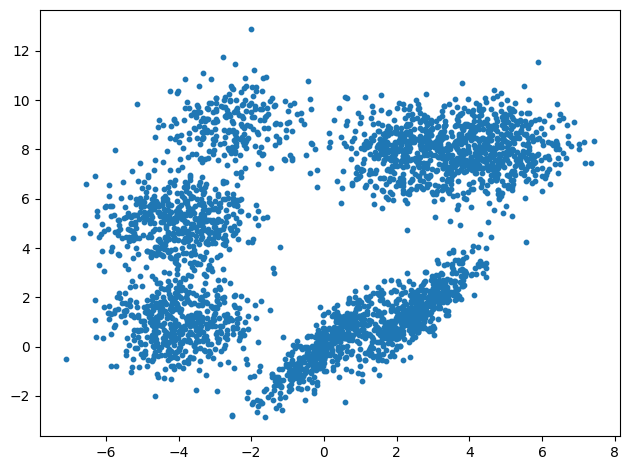

In [57]:
X_clusters = df_clusters.values
plot_clusters(X_clusters, s=10)

### Hierarchical

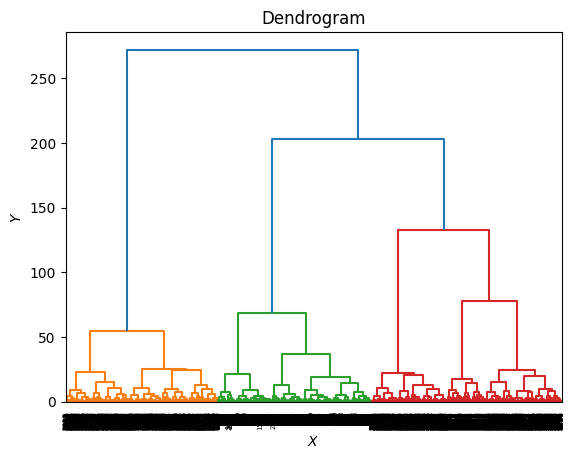

In [15]:
dendrogram = sch.dendrogram(sch.linkage(X_clusters, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('$X$')
plt.ylabel('$Y$')
plt.show()

Del dendograma anterior, podemos ver que un buen hiperparámetro para agrupamiento jerárquico es utilizar cinco clústers. Dado que para este utilizamos el método `ward`, usaremos los mismos hiperparámetros en el algoritmo.

Puntuacion Davis-Bouldin: 0.5577762031566917


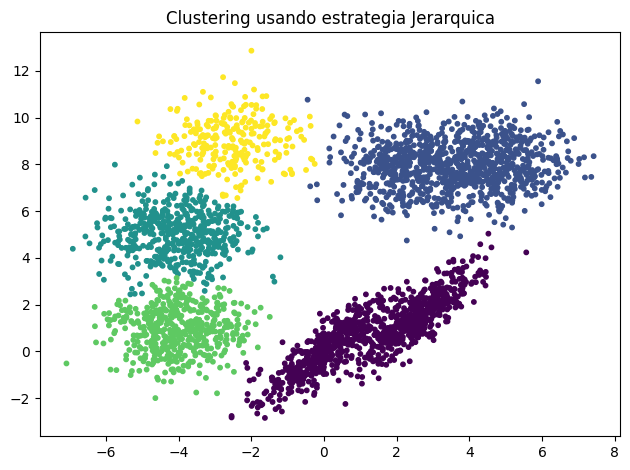

In [24]:
hc = cluster_strat(X_clusters, strat='hierarchy', n_clusters=5, linkage='ward')
bd_hc_score = davies_bouldin_score(X_clusters, hc.labels_)
print(f"Puntuacion Davis-Bouldin: {bd_hc_score}")
plt.title("Clustering usando estrategia Jerarquica")
plot_clusters(X_clusters, hc.labels_, s=10)

### KMeans

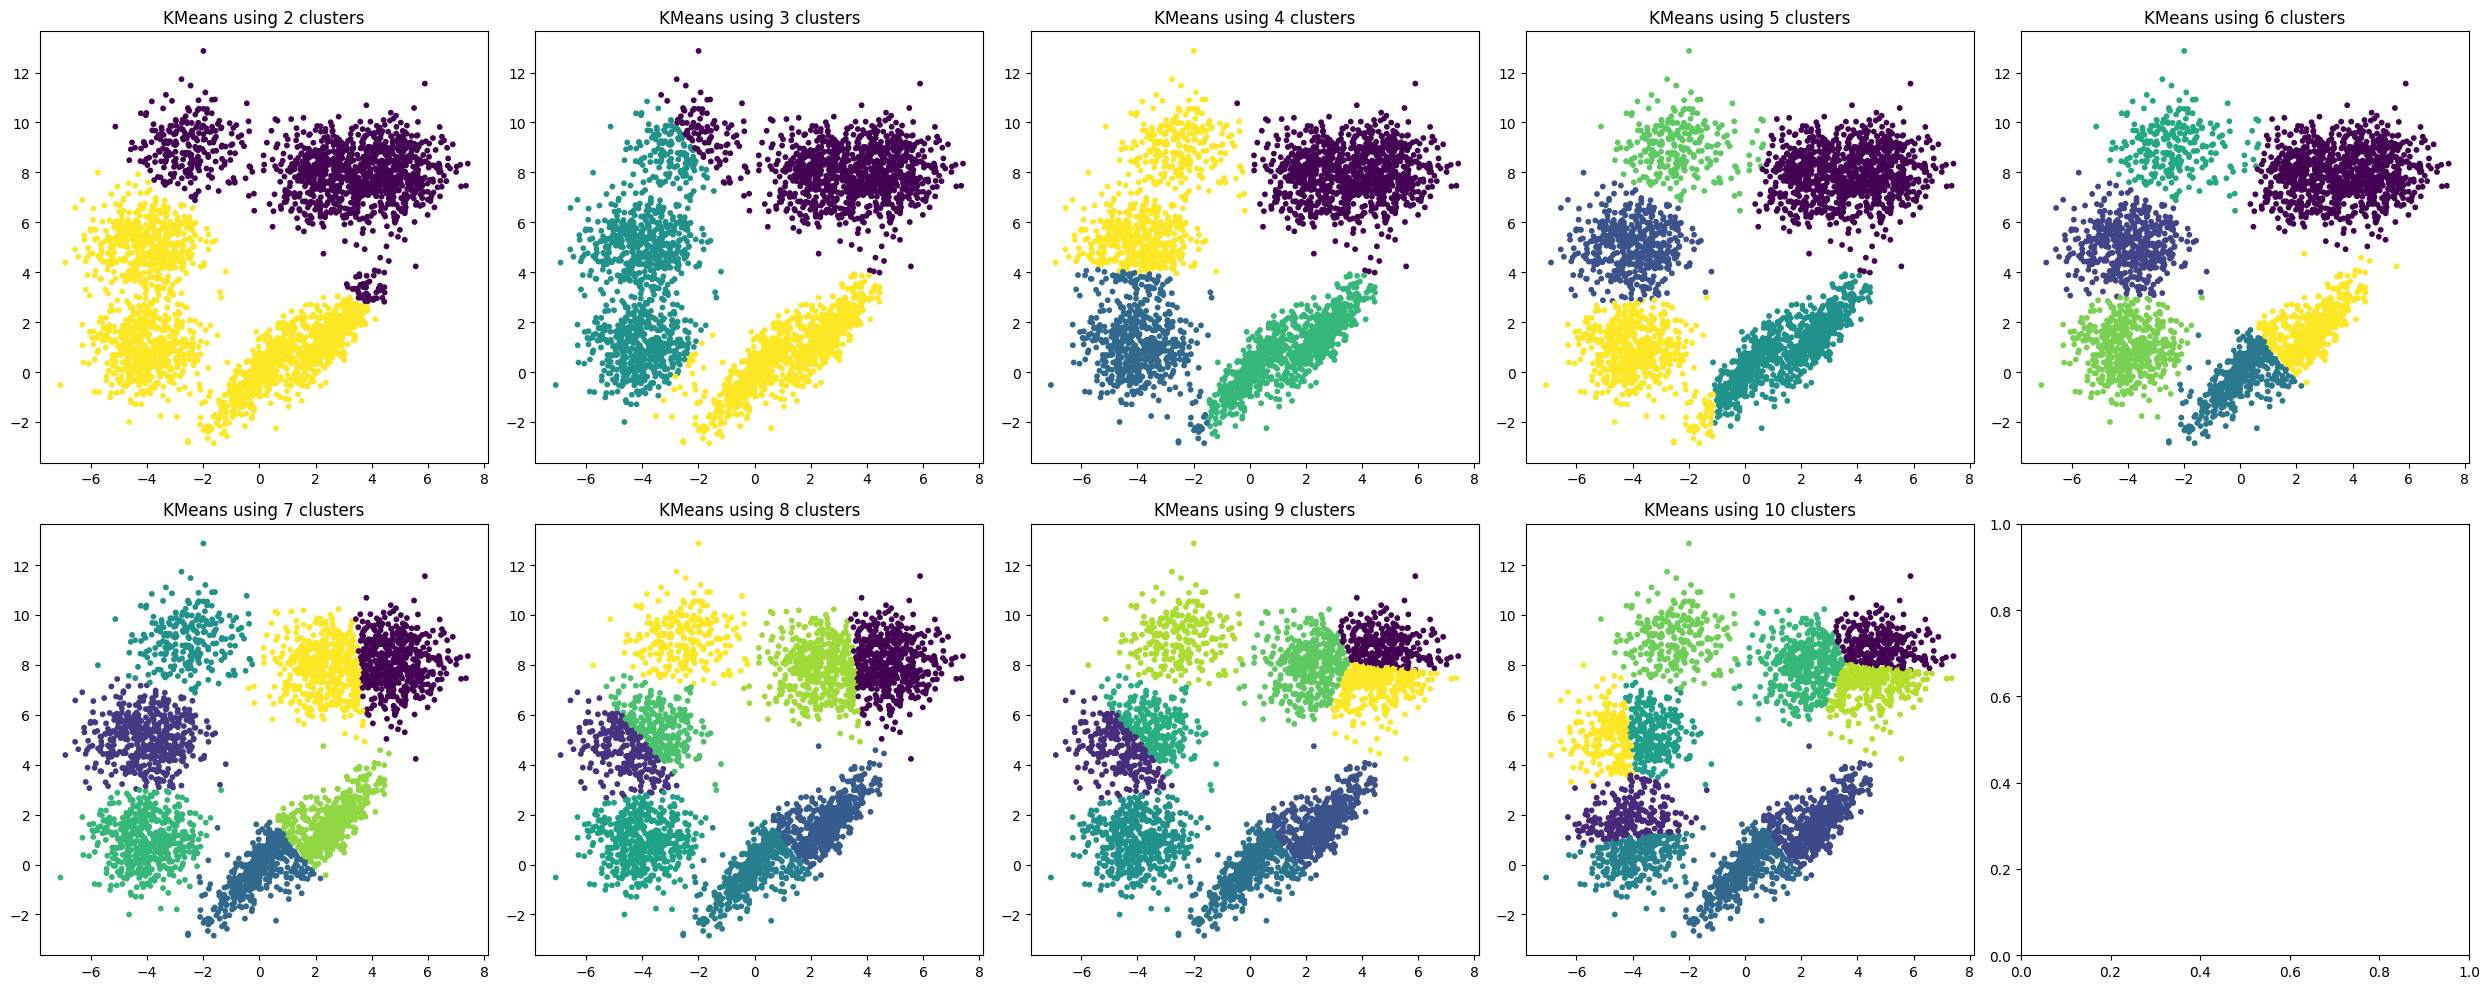

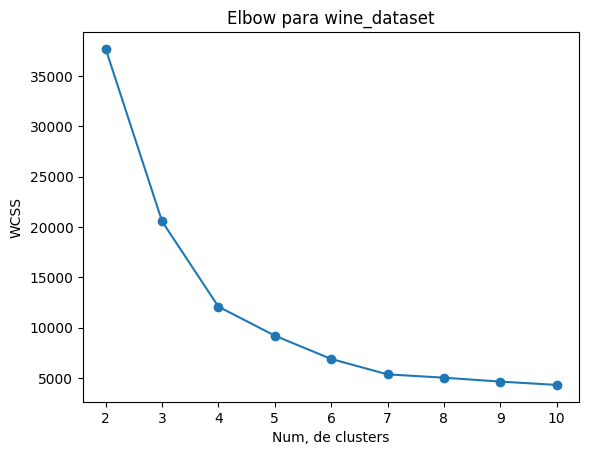

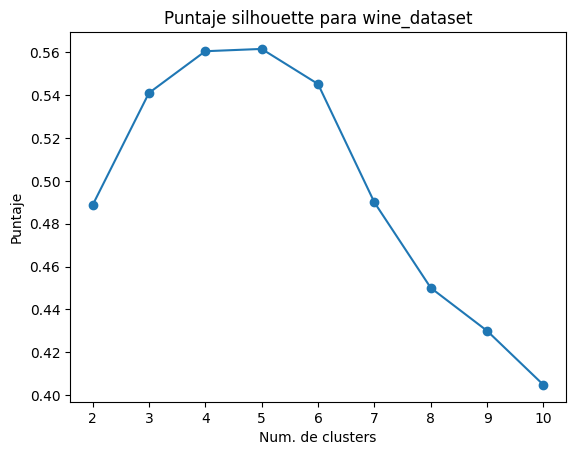

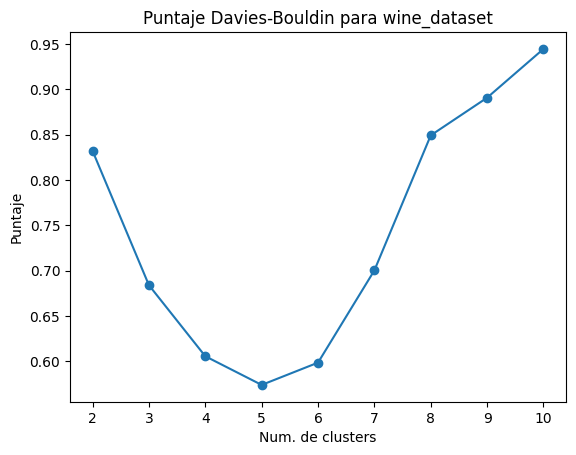

In [42]:
N_ROWS = 2
N_COLS = 5
fig, axs = plt.subplots(N_ROWS, N_COLS, figsize=(25,10))

wcss = []
silhouette_scores = []
db_scores = []
for col_idx, i in enumerate(range(2, 11)):
    plot_row = 0 if i <= (N_COLS+1) else 1
    kmean = cluster_strat(X_clusters, n_clusters=i)
    wcss.append(kmean.inertia_)
    silhouette_scores.append(silhouette_score(X_clusters, kmean.labels_))
    db_scores.append(davies_bouldin_score(X_clusters, kmean.labels_))
    axs[plot_row, col_idx % N_COLS].set_title(f"KMeans using {i} clusters")
    plot_clusters(X_clusters, kmean.labels_, s=10, ax=axs[plot_row, col_idx % N_COLS])
    
plt.show()

plot_metric(2, 10, wcss, title='Elbow para wine_dataset', 
            x_label='Num, de clusters', y_label='WCSS')
        
plot_metric(2, 10, silhouette_scores, title='Puntaje silhouette para wine_dataset',
            x_label='Num. de clusters', y_label='Puntaje')
    
plot_metric(2, 10, db_scores, title='Puntaje Davies-Bouldin para wine_dataset',
            x_label='Num. de clusters', y_label='Puntaje')

Una vez más, notamos que con cinco clusters tenemos una agrupación relativamente adecuada, mientras que para números más grandes o más pequeños a este las agrupaciones son erráticas. Notemos que el número de clusters que mejor separan los
grupos es cinco.

### DBSCAN

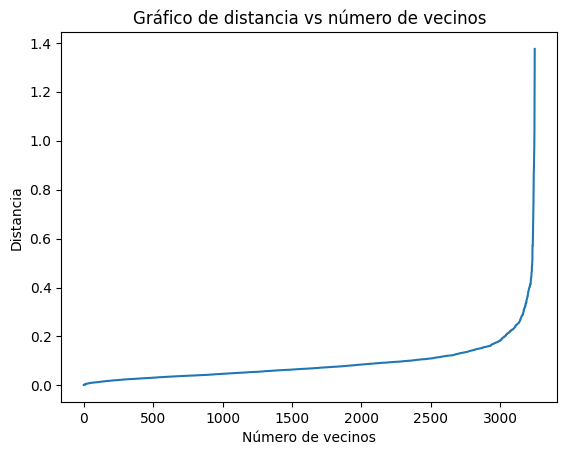

In [47]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_clusters)
distances, indices = nbrs.kneighbors(X_clusters)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.xlabel('Número de vecinos')
plt.ylabel('Distancia')
plt.title('Gráfico de distancia vs número de vecinos')
plt.show()

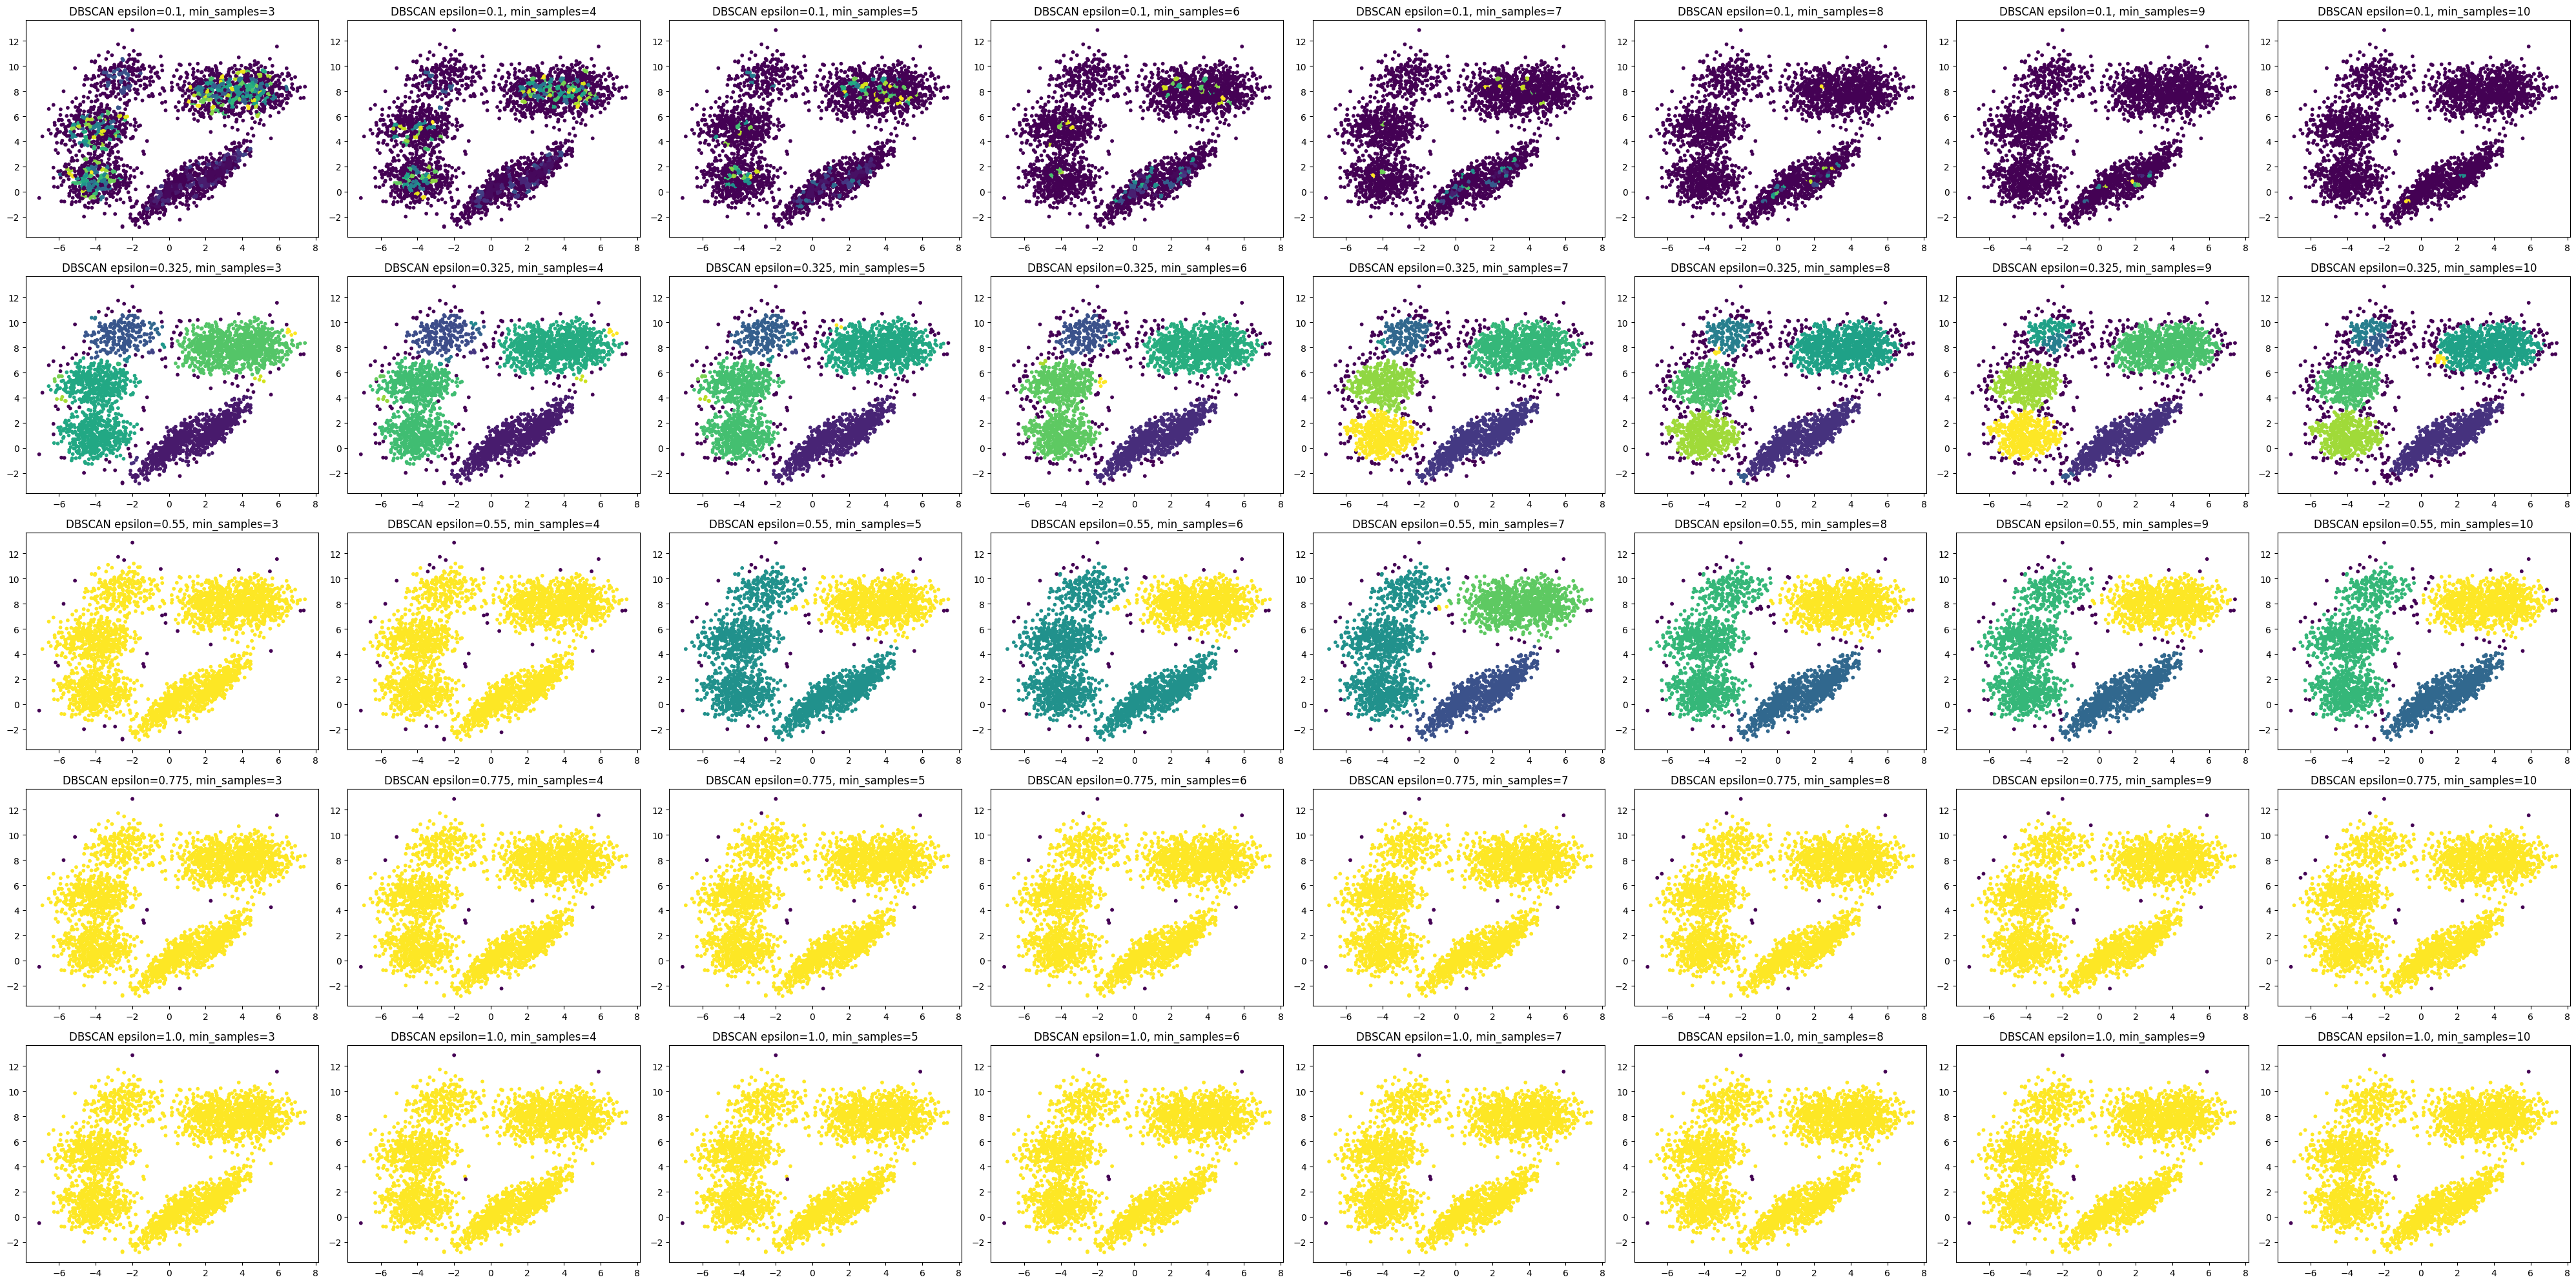

In [91]:
epsilons = np.linspace(0.1, 1, 5)
min_samples_values = range(3, 11)

ch_scores = []
db_scores = []
silhouette_scores = []

N_ROWS = len(epsilons)
N_COLS = len(min_samples_values)
fig, axs = plt.subplots(N_ROWS, N_COLS, figsize=(40,20))

for row_idx, eps_i in enumerate(epsilons):
    #if i == 0.: continue
    for col_idx, sv_j in enumerate(min_samples_values):
        dbsc = cluster_strat(X_clusters, strat='dbscan', 
                             epsilon=eps_i, samples=sv_j)
        silhouette_scores.append(silhouette_score(X_clusters, dbsc.labels_))
        db_scores.append(davies_bouldin_score(X_clusters, dbsc.labels_))
        ch_scores.append(calinski_harabasz_score(X_clusters, dbsc.labels_))
        axs[row_idx, col_idx].set_title(f"DBSCAN epsilon={eps_i}, min_samples={sv_j}")
        plot_clusters(X_clusters, dbsc.labels_, s=10, ax=axs[row_idx, col_idx])

In [ ]:
plt.figure(figsize=(12,4))
for i, eps in enumerate(epsilons):
    plt.plot(min_samples_values, db_scores[i], marker='o', label=f"epsilon {eps}")
    
plt.xlabel("Min. de muestras")
plt.ylabel("Davies-Bouldin score")
plt.legend()
plt.tight_layout()
plt.show()

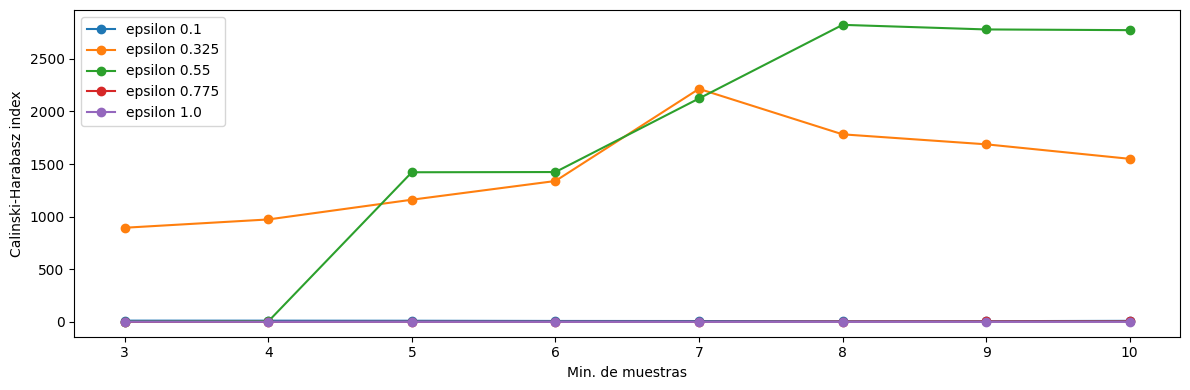

In [75]:
plt.figure(figsize=(12,4))
for i, eps in enumerate(epsilons):
    plt.plot(min_samples_values, ch_scores[i], marker='o', label=f"epsilon {eps}")
    
plt.xlabel("Min. de muestras")
plt.ylabel("Calinski-Harabasz index")
plt.legend()
plt.tight_layout()
plt.show()

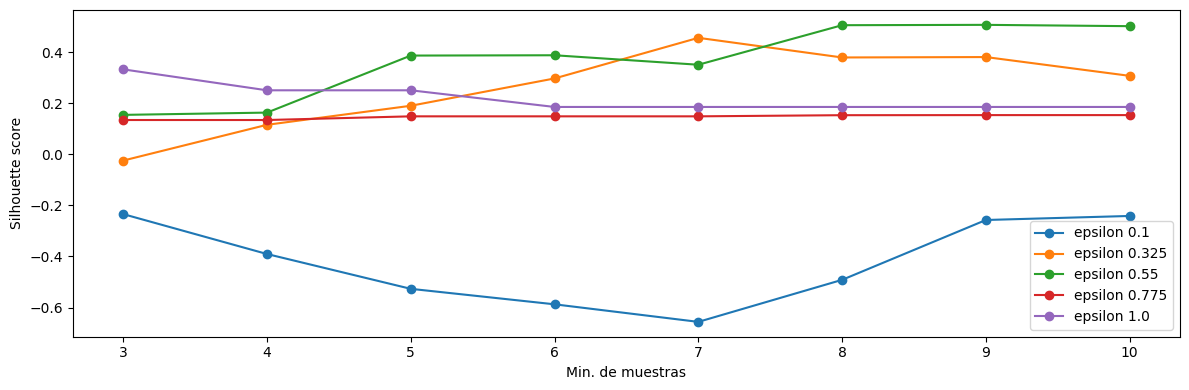

In [71]:
plt.figure(figsize=(12,4))
for i, eps in enumerate(epsilons):
    plt.plot(min_samples_values, silhouette_scores[i], marker='o', label=f"epsilon {eps}")
    
plt.xlabel("Min. de muestras")
plt.ylabel("Silhouette score")
plt.legend()
plt.tight_layout()
plt.show()

DBSCAN presenta un buen agrupamiento cuando el número de muestras es diez, mientras que las epislon candidatas con los mejores resultados son 0.55 y 0.325. Sin embargo, notamos en los primeros mapas de clustering presentados que incluso la mejor 
combinación de estos No consigue asignar correctamente todos los puntos: mientras la combinación `(epsilon=0.325, min_samples_values=10)` clasifica grupos distinguibles también clasifica demasiados puntos como ruido. En cambio, la combinación 
`(epsilon=0.55, min_samples_values=10)` reduce las clasificaciones como ruido, pero no crea grupos diferentes.

### Gaussian Mixture

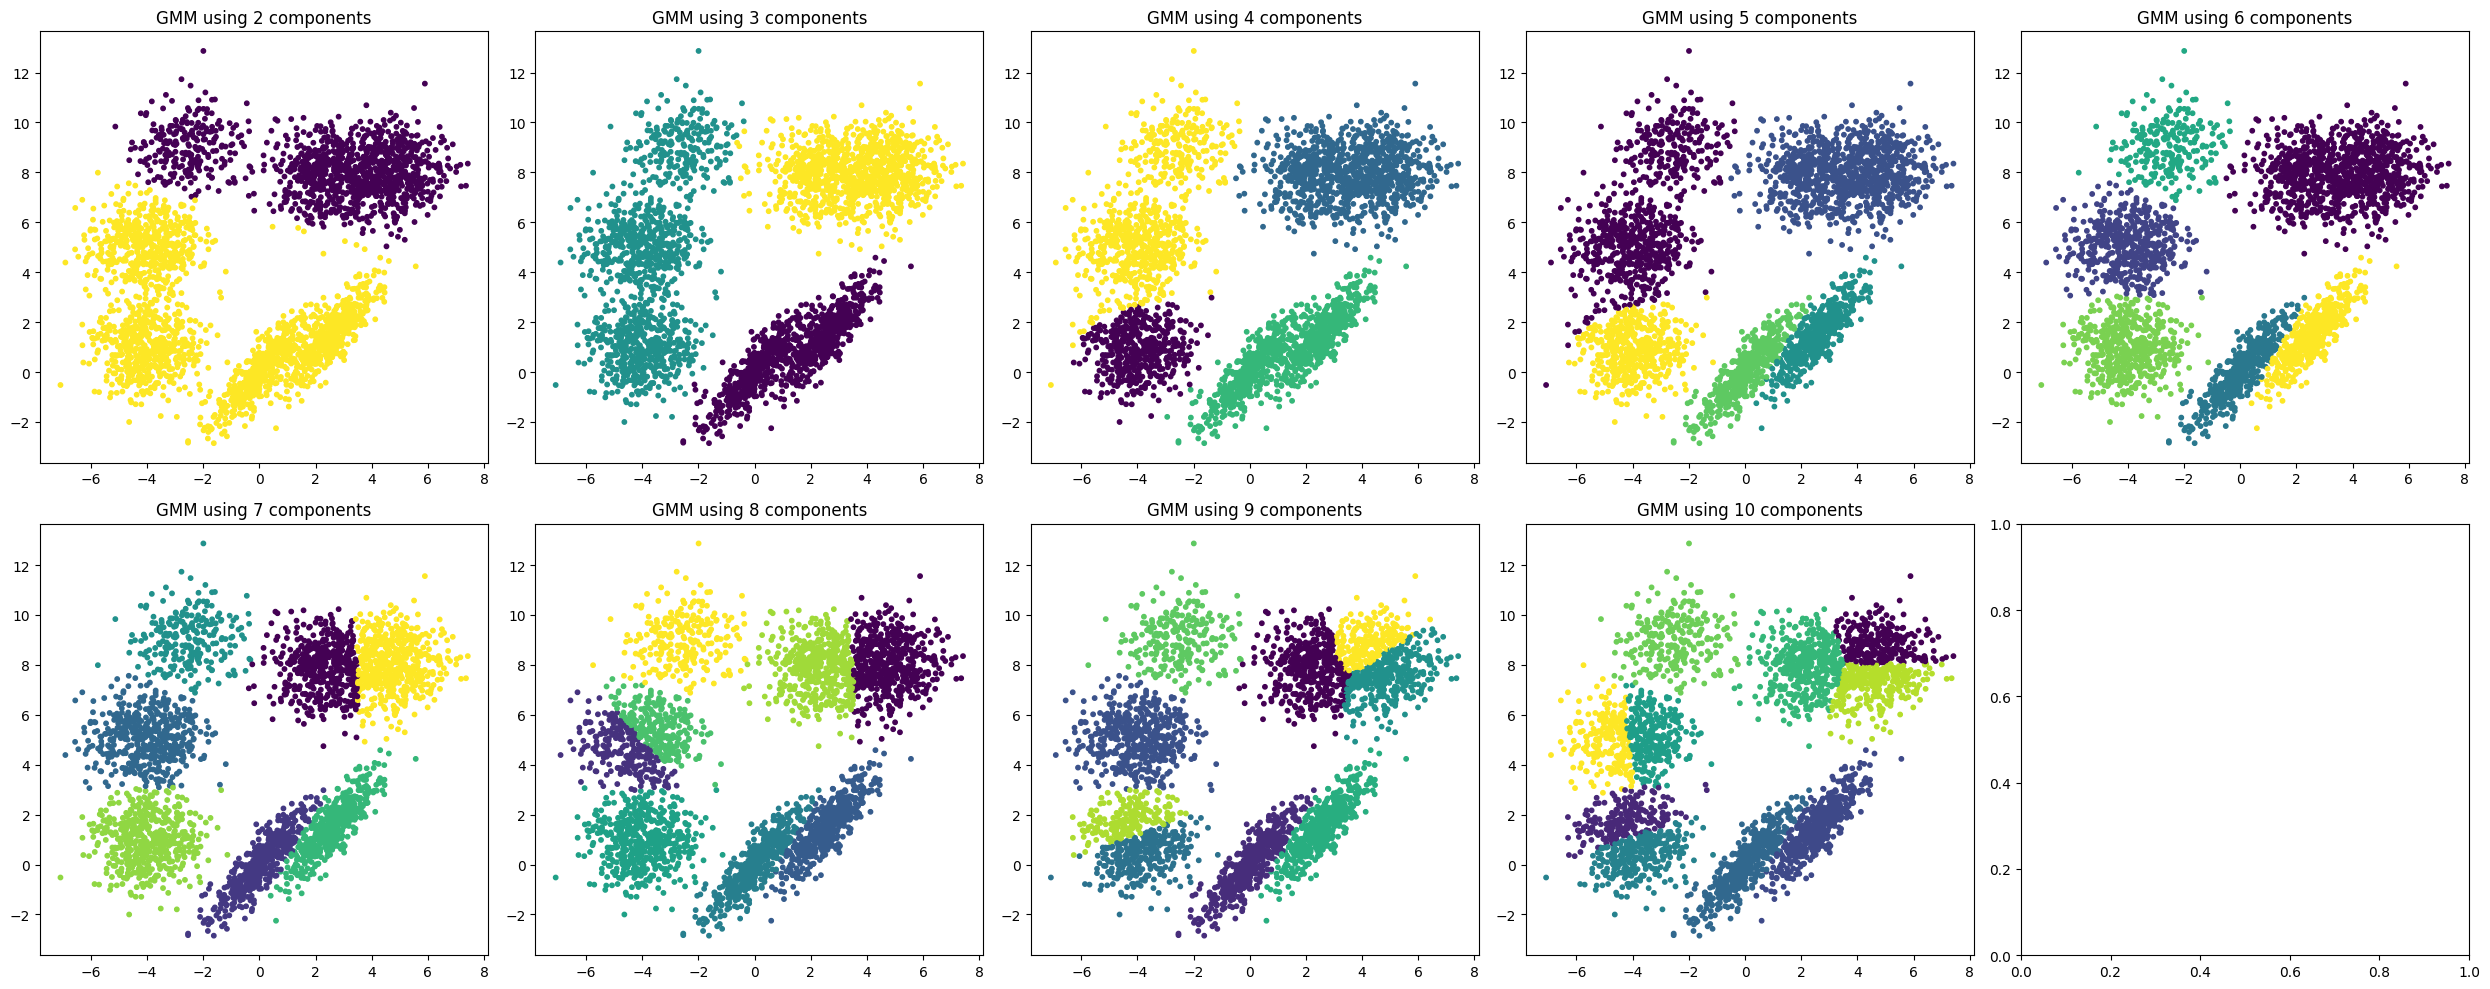

In [81]:
N_ROWS = 2
N_COLS = 5
fig, axs = plt.subplots(N_ROWS, N_COLS, figsize=(25,10))

aics = []
bics = []
silhouette_scores = []
for col_idx, i in enumerate(range(2,11)):
    if i == 0.: continue
    plot_row = 0 if i <= (N_COLS + 1) else 1
    gmm = cluster_strat(X_clusters, strat='gmm', n_components=i)
    labels = gmm.predict(X_clusters)
    bics.append(gmm.bic(X_clusters))
    aics.append(gmm.aic(X_clusters))
    silhouette_scores.append(silhouette_score(X_clusters, labels))
    axs[plot_row, col_idx % N_COLS].set_title(f"GMM using {i} components")
    plot_clusters(X_clusters, labels, s=10, ax=axs[plot_row, col_idx % N_COLS])

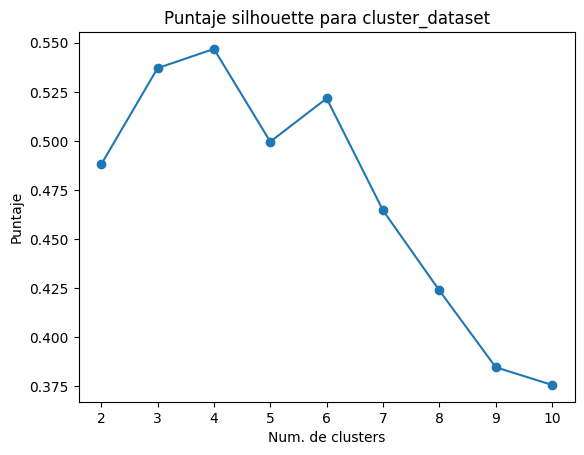

In [86]:
plot_metric(2, 10, silhouette_scores, title='Puntaje silhouette para cluster_dataset',
            x_label='Num. de clusters', y_label='Puntaje')

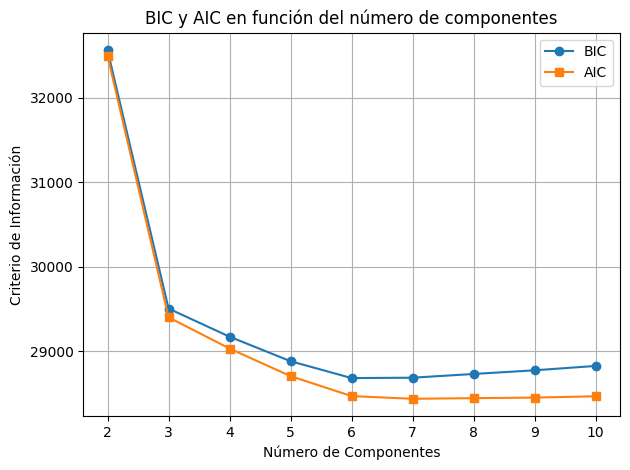

In [82]:
plt.plot(range(2, 11), bics, label='BIC', marker='o')
plt.plot(range(2, 11), aics, label='AIC', marker='s')
plt.xlabel('Número de Componentes')
plt.ylabel('Criterio de Información')
plt.title('BIC y AIC en función del número de componentes')
plt.xticks(np.arange(2, 11, 1))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

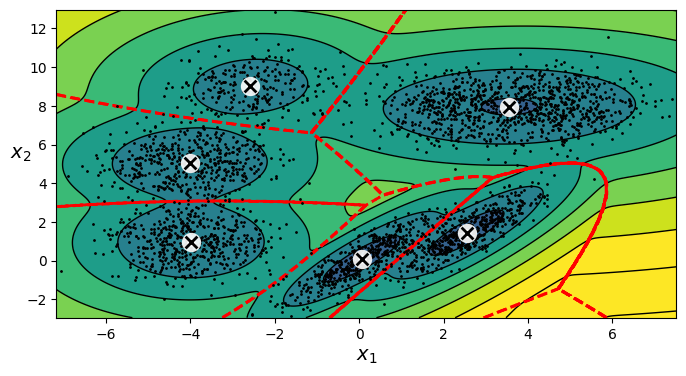

In [84]:
from matplotlib.colors import LogNorm

gm = GaussianMixture(n_components=6, n_init=7, random_state=42)
gm.fit(X_clusters)
labels = gm.predict(X_clusters)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')

    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X_clusters)

plt.show()

Podemos observar con las métricas que este modelo se comporta perfecto usando un número de componentes igual a seis. Observando la 
última gráfica y la correspondiente a esta cantidad de componentes entre el resto, podemos notar que el algoritmo consigue definir 
buenas fronteras de clasificación, inclusive donde algoritmos previos mezclaban grupos de puntos.

# Conclusiones
---
El **número de clústers adecuado** para este conjunto es entre 5 y 6 dependiendo del modelo con base en las métricas de silueta, wcss y Davies-Bouldin, que nos indican buenos puntajes en estos valores. 

El **mejor modelo** y que mejor clasifica los grupos es `GaussianMixture`, siendo el que separa de manera más suave y concisa los 
grupos, utilizando seis clústers.